## Libraries 

In [ ]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F



c:\Users\timne\AppData\Local\Programs\Python\Python313\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Augmentation of Dataset for 20 -> 100 images

In [ ]:
# Setting Transform for Augmentations
transform = A.Compose([
    A.GaussNoise(var_limit=(10, 50), p=0.5), # Add Gaussian noise with variable intensity
    A.Rotate(limit=30, p=0.7), # Randomly rotate image within ±30 degrees
    A.HorizontalFlip(p=0.5), # Flip image horizontally with 50% chance
    A.RandomBrightnessContrast(p=0.6) # Randomly adjust brightness and contrast
])

# Folder function to store augmented images
def augment_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True) # Create output folder if did not exist
    images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.png'))]

    for img_name in tqdm(images, desc=f"Augmenting images in {input_folder}"):
        img_path = os.path.join(input_folder, img_name)
        image = cv2.imread(img_path)
        base_name = os.path.splitext(img_name)[0]

        # Save original image
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_original.jpg"), image)

        # Augment 4 versions per image
        for i in range(4):  # Augment until 100 total
            augmented = transform(image=image)["image"] # Applying augmentation
            cv2.imwrite(os.path.join(output_folder, f"{base_name}_aug{i}.jpg"), augmented)

# Creating the augmented dataset
def augment_dataset(root="Datasets", output="Augmented_2"):
    for fruit in os.listdir(root):  # Loop through fruit types
        fruit_path = os.path.join(root, fruit)
        if not os.path.isdir(fruit_path):
            continue
        for ripeness in os.listdir(fruit_path): # Loop through ripeness categories
            input_folder = os.path.join(fruit_path, ripeness)
            output_folder = os.path.join(output, fruit, ripeness)
            augment_folder(input_folder, output_folder,)

augment_dataset("Datasets", "Augmented_2")



In [ ]:

# Pytorch Dataset for fruit ripness Classification
class FruitRipenessDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []       # Stores full path to all imgs
        self.labels = []            # Stores correspoding class labels
        self.transform = transform  # Optional image transforms (e.g., resize, normalize)
        self.class_map = {}         # Map class name to numerics. e.g., {'Banana_Ripe': 0, 'Banana_Unripe': 1, ...}
        class_index = 0             # Counter for assigning class labels
        
        # Loop through all classes in root_dir
        for class_name in sorted(os.listdir(root_dir)):
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue

            self.class_map[class_name] = class_index # Map class name to label index

            # Loop through all imgs in class folder
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(img_path) # Save img path
                    self.labels.append(class_index)   # Save corresponding label
            class_index += 1 # Move to next class label

    def __len__(self):
        return len(self.image_paths) # Get total number of imgs in dataset 

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")  # Open img and convert to RGB
        label = self.labels[idx] # Get img label
        if self.transform:
            img = self.transform(img) # Apply tansform if provided
        return img, label

In [ ]:

# Split dataset from Augmented into Train/Val/Test (70/20/10)
def split_dataset(input_dir="Augmented_2", output_dir="FruitData_2", train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
    random.seed(seed)

    # Loop through each fruit category
    for fruit in os.listdir(input_dir):
        fruit_path = os.path.join(input_dir, fruit)
        if not os.path.isdir(fruit_path):
            continue
        
        # Loop through ripeness (Ripe and Unripe)
        for ripeness in os.listdir(fruit_path):
            class_name = f"{fruit}_{ripeness}"
            class_path = os.path.join(fruit_path, ripeness) # Combine class label to be Fruit_Ripness 

            # Get all imgs in class folder
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]
            random.shuffle(images) # Shuffle for random splitting

            # Calculate split indices
            total = len(images)
            train_end = int(train_ratio * total)
            val_end = train_end + int(val_ratio * total)

            # Split into train val test
            splits = {
                "train": images[:train_end],
                "val": images[train_end:val_end],
                "test": images[val_end:]
            }

            for split, split_images in splits.items():
                split_folder = os.path.join(output_dir, split, class_name)
                os.makedirs(split_folder, exist_ok=True)

                for img_name in split_images:
                    src = os.path.join(class_path, img_name) # source img path
                    dst = os.path.join(split_folder, img_name) # Destination path
                    shutil.copy2(src, dst) # Copy img to destination

    print(f"Dataset split performed and saved into: {output_dir}/train, /val, /test")

split_dataset()



## 4. a. Custom Transform - Hue Extraction and Masking

In [ ]:

class HueTransform:
    def __init__(self, resize=(244, 244), hue_range=None, debug=False):
        self.resize = resize
        self.hue_range = hue_range
        self.debug = debug
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        if self.debug:
            plt.figure(figsize=(6, 3))
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title("Original RGB")
            plt.axis("off")

        # Convert to HSV and extract hue channel
        hsv = np.array(img.convert("HSV"))
        hue = hsv[:, :, 0]

        if self.hue_range:
            mask = (hue >= self.hue_range[0]) & (hue <= self.hue_range[1])
            hue = np.where(mask, hue, 0)

        # Normalize hue and stack to 3-channel image
        hue = hue.astype(np.float32) / 255.0
        hue_img = np.stack([hue] * 3, axis=2)  # Grayscale hue mask repeated in RGB

        # Convert to PIL and resize
        hue_img = Image.fromarray((hue_img * 255).astype(np.uint8))
        hue_img = hue_img.resize(self.resize)

        # Show processed image
        if self.debug:
            plt.subplot(1, 2, 2)
            plt.imshow(hue_img)
            plt.title("Hue-Masked RGB")
            plt.axis("off")
            plt.tight_layout()
            plt.show()

        return self.to_tensor(hue_img)

## 4. b. RGB Transformation

In [ ]:
# Values for Dataset Mean and STD: mean=[0.5356, 0.4985, 0.3548], std=[0.2257, 0.2288, 0.2137]
# Define transforms for original RGB images
rgb_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5356, 0.4985, 0.3548], std=[0.2257, 0.2288, 0.2137]) # Corrected mean
])

### Debug to view images

In [ ]:
# DEBUG TEST

# Use debug=True to visualize RGB before and after hue masking
debug_transform = HueTransform(resize=(244, 244), hue_range=(20, 40), debug=True)

# Load a few samples with debugging turned on
debug_dataset = FruitRipenessDataset(root_dir='FruitData_2/train', transform=debug_transform)

# Show the first 3 images and their transformations
for i in range(3):
    img, label = debug_dataset[i]  # This will trigger the debug plots

### Hue or RGB Transformation application

In [3]:
# Apply the custom hue transform
#hue_transform = HueTransform(resize=(244, 244), hue_range=None, debug=False)  # Adjust range as needed

# Use ImageFolder with folder name as class label
train_dataset = ImageFolder(root='FruitData_2/train', transform=rgb_transform)
val_dataset = ImageFolder(root='FruitData_2/val', transform=rgb_transform)
test_dataset = ImageFolder(root='FruitData_2/test', transform=rgb_transform)

# Class to index mapping
print(train_dataset.class_to_idx)

{'Banana_Ripe': 0, 'Banana_Unripe': 1, 'Mango_Ripe': 2, 'Mango_Unripe': 3, 'Rambutan_Ripe': 4, 'Rambutan_Unripe': 5, 'Strawberry_Ripe': 6, 'Strawberry_Unripe': 7, 'Tomato_Ripe': 8, 'Tomato_Unripe': 9}


### Temporary Loader Check 

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

temp_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor()
])
temp_dataset = ImageFolder(root='FruitData_2/train', transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=1, shuffle=True)

for img, label in temp_loader:
    print("Tensor shape:", img.shape)
    print("Min pixel value:", torch.min(img))
    print("Max pixel value:", torch.max(img))
    break # Only check the first image

Tensor shape: torch.Size([1, 3, 244, 244])
Min pixel value: tensor(0.)
Max pixel value: tensor(1.)


## Mean and STD calculation (For Normalization input)

In [ ]:
def calculate_mean_std(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_samples = 0
    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, 3, -1)
        mean += images.mean(dim=2).sum(dim=0)
        std += images.std(dim=2).sum(dim=0)
        total_samples += batch_size
    mean /= total_samples
    std /= total_samples
    return mean, std

transform_for_stats = transforms.Compose([
    transforms.Resize((256, 256)), # Or (244, 244)
    transforms.ToTensor()
])

temp_loader_stats = DataLoader(
    ImageFolder(root='FruitData_2/train', transform=transform_for_stats),
    batch_size=32,
    shuffle=False
)

mean, std = calculate_mean_std(temp_loader_stats)
print("Calculated Mean:", mean)
print("Calculated Std:", std)

### Sample checker

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1787586..2.7989762].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3730617..3.0191858].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3730617..2.7806253].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3730617..2.138347].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3730617..2.2117503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2340605..1.9731896].


Batch shape: torch.Size([32, 3, 244, 244])


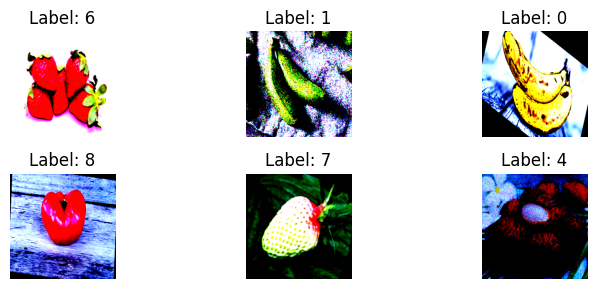

In [ ]:
# Check a sample
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)

# Show a few images
plt.figure(figsize=(8, 3))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img, cmap='gray')  # grayscale look
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 5. a. CNN Model (First Iteration) 

In [ ]:
class FruitCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(FruitCNN, self).__init__() # Initialize CNN
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 3 input (RGB), 16 output, 3x3, 1 padding
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 16 input, 32 output, 3x3, 1 padding
        self.pool = nn.MaxPool2d(2, 2)  # Halves the image size
        # Fully connected layer 1: Img size is now (32, 61, 61) - 32 channels, each 61x61; flattened into 1D (32*61*61)
        self.fc1 = nn.Linear(32 * 61 * 61, 128)  # Adjusted for input size 244x244
        self.fc2 = nn.Linear(128, num_classes) # Fully connected layer 2: output size is 10 (num of classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1 -> ReLU -> max pool; (Output: 16,122,122)
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2 -> ReLU -> max pool; (Output: 32,61,61)
        x = x.view(-1, 32 * 61 * 61)          # Flatten to 1D
        x = F.relu(self.fc1(x)) # Apply fully connected layer 1 with ReLU
        x = self.fc2(x) # Apply fully connected layer 2 to output (batch size, num classes)
        return x

# 5. b. CNN Model (Improved)

In [ ]:
class FruitCNNImproved(nn.Module):
    def __init__(self, num_classes=10):
        super(FruitCNNImproved, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 61 * 61, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 61 * 61)
        x = self.dropout(x)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x

## 6. Training Tools 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set device to GPU if available
model = FruitCNNImproved(num_classes=10).to(device) # Initialize CNN and move to selected device
criterion = nn.CrossEntropyLoss() # Define loss function (CrossEntropy)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Define optimizer (Adam)

## 7. Training and Validation Functions

In [9]:
def train(model, dataloader, optimizer, criterion):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update weights

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = correct / total  # Calculate accuracy
    return total_loss / len(dataloader), accuracy  # Return average loss and accuracy


def validate(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = correct / total  # Calculate accuracy
    return total_loss / len(dataloader), accuracy  # Return average loss and accuracy

## 8. Training Loop

In [10]:
epochs = 10  # Number of epochs to train the model

train_losses, val_losses = [], []  # Lists to store loss values
train_accuracies, val_accuracies = [], []  # Lists to store accuracy values

for epoch in range(epochs):  # Loop through each epoch
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)  # Train the model
    val_loss, val_acc = validate(model, val_loader, criterion)  # Validate the model

    # Append the losses and accuracies for each epoch
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print the results for this epoch
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")  # Training stats
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")  # Validation stats


Epoch 1/10
Train Loss: 1.8013, Accuracy: 0.3771
Val   Loss: 1.7174, Accuracy: 0.4250
Epoch 2/10
Train Loss: 1.2147, Accuracy: 0.6914
Val   Loss: 1.3787, Accuracy: 0.5850
Epoch 3/10
Train Loss: 0.7888, Accuracy: 0.8671
Val   Loss: 1.1347, Accuracy: 0.6800
Epoch 4/10
Train Loss: 0.4291, Accuracy: 0.9643
Val   Loss: 0.8540, Accuracy: 0.7600
Epoch 5/10
Train Loss: 0.2161, Accuracy: 0.9943
Val   Loss: 0.8615, Accuracy: 0.7550
Epoch 6/10
Train Loss: 0.1123, Accuracy: 1.0000
Val   Loss: 0.6325, Accuracy: 0.8200
Epoch 7/10
Train Loss: 0.0594, Accuracy: 1.0000
Val   Loss: 0.6345, Accuracy: 0.8250
Epoch 8/10
Train Loss: 0.0403, Accuracy: 1.0000
Val   Loss: 0.6207, Accuracy: 0.8100
Epoch 9/10
Train Loss: 0.0301, Accuracy: 1.0000
Val   Loss: 0.5822, Accuracy: 0.8300
Epoch 10/10
Train Loss: 0.0217, Accuracy: 1.0000
Val   Loss: 0.5851, Accuracy: 0.8100


## 9. Results/Visualizations
## 9. a. Loss/Accuracy over Epochs Visualization

In [ ]:
# Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

## 9. b. Confusion Matrix Visualization

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Saving Model

In [ ]:
torch.save(model.state_dict(), 'FruitCNN_RGB_Mean_Std.pth')

## 9. c. Checking Misclassified

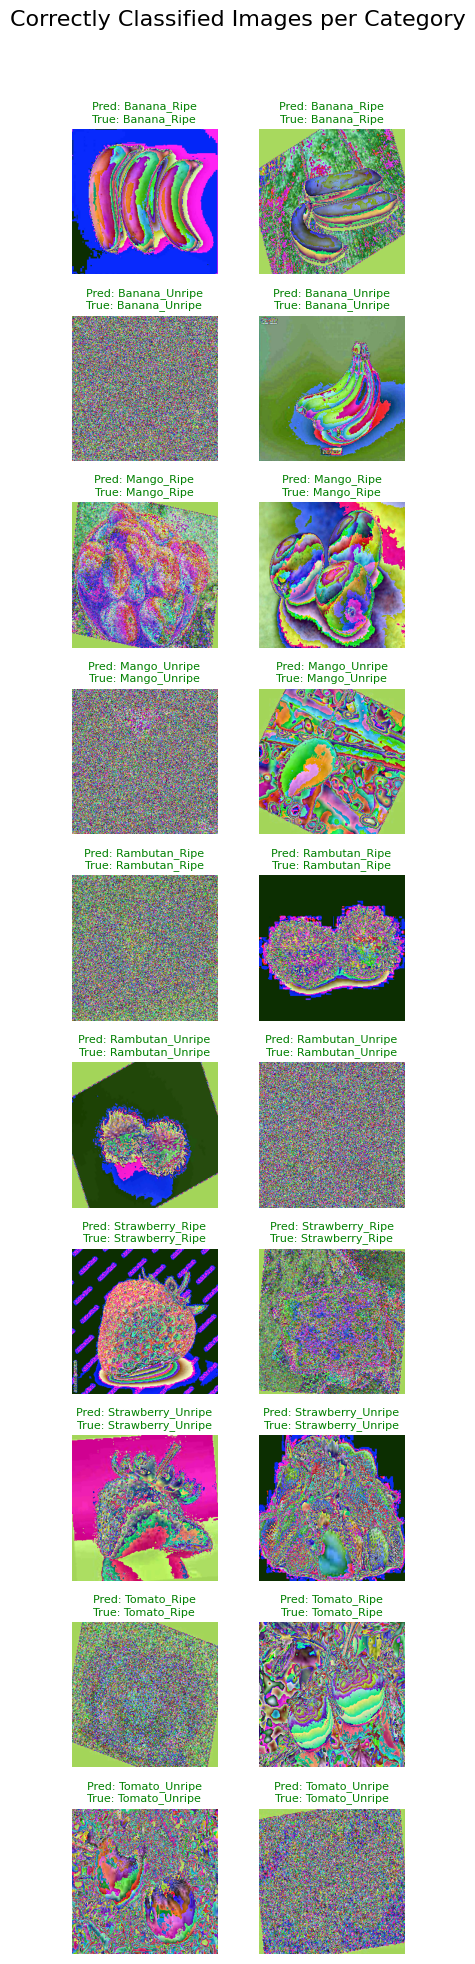

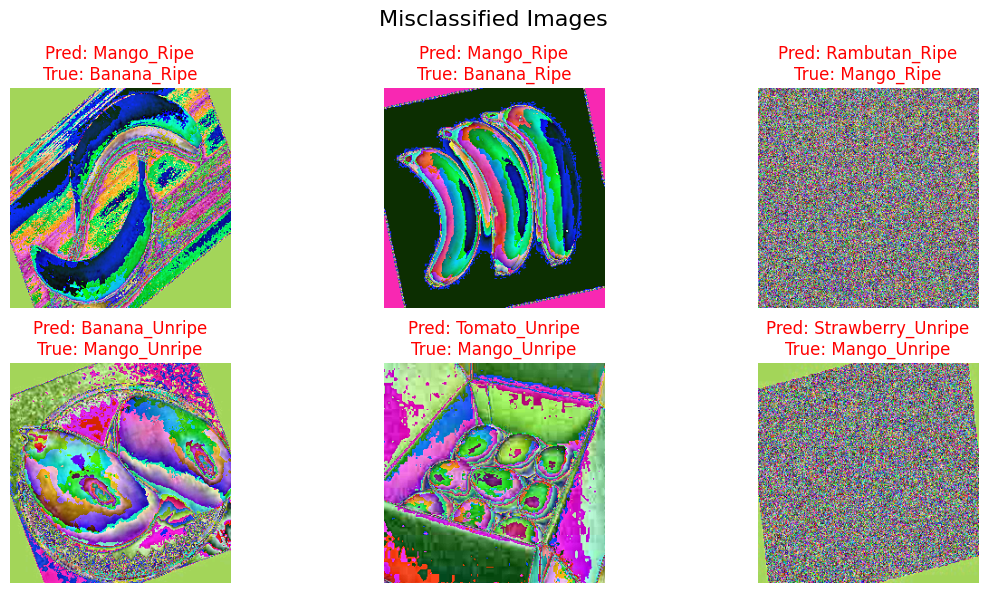

In [11]:
# Put model in evaluation mode
model.eval()

correctly_classified_by_class = {class_name: [] for class_name in train_dataset.classes}
misclassified = []
num_samples_per_class = 2 # number of samples you want to visualize per class

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            pred_label = preds[i].item()
            true_label = labels[i].item()
            img_tensor = images[i]
            class_name = train_dataset.classes[true_label]

            if pred_label == true_label and len(correctly_classified_by_class[class_name]) < num_samples_per_class:
                correctly_classified_by_class[class_name].append((img_tensor, pred_label, true_label))
            elif pred_label != true_label and len(misclassified) < 6:  # Limit total misclassified for visualization
                misclassified.append((img_tensor, pred_label, true_label))

# Get label names from dataset
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}

# Plot correctly classified images from each category
num_rows_correct = len(train_dataset.classes)
num_cols = num_samples_per_class
plt.figure(figsize=(2 * num_cols, 2 * num_rows_correct))
plot_index = 1
for class_name, samples in correctly_classified_by_class.items():
    for img_tensor, pred_label, true_label in samples:
        img = transforms.ToPILImage()(img_tensor.cpu())
        plt.subplot(num_rows_correct, num_cols, plot_index)
        plt.imshow(img)
        plt.title(f"Pred: {idx_to_class[pred_label]}\nTrue: {idx_to_class[true_label]}", color='green', fontsize=8)
        plt.axis("off")
        plot_index += 1
plt.tight_layout()
plt.suptitle("Correctly Classified Images per Category", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

# Plot misclassified images
plt.figure(figsize=(12, 6))
for i, (img_tensor, pred_label, true_label) in enumerate(misclassified[:6]):
    img = transforms.ToPILImage()(img_tensor.cpu())
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {idx_to_class[pred_label]}\nTrue: {idx_to_class[true_label]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.suptitle("Misclassified Images", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

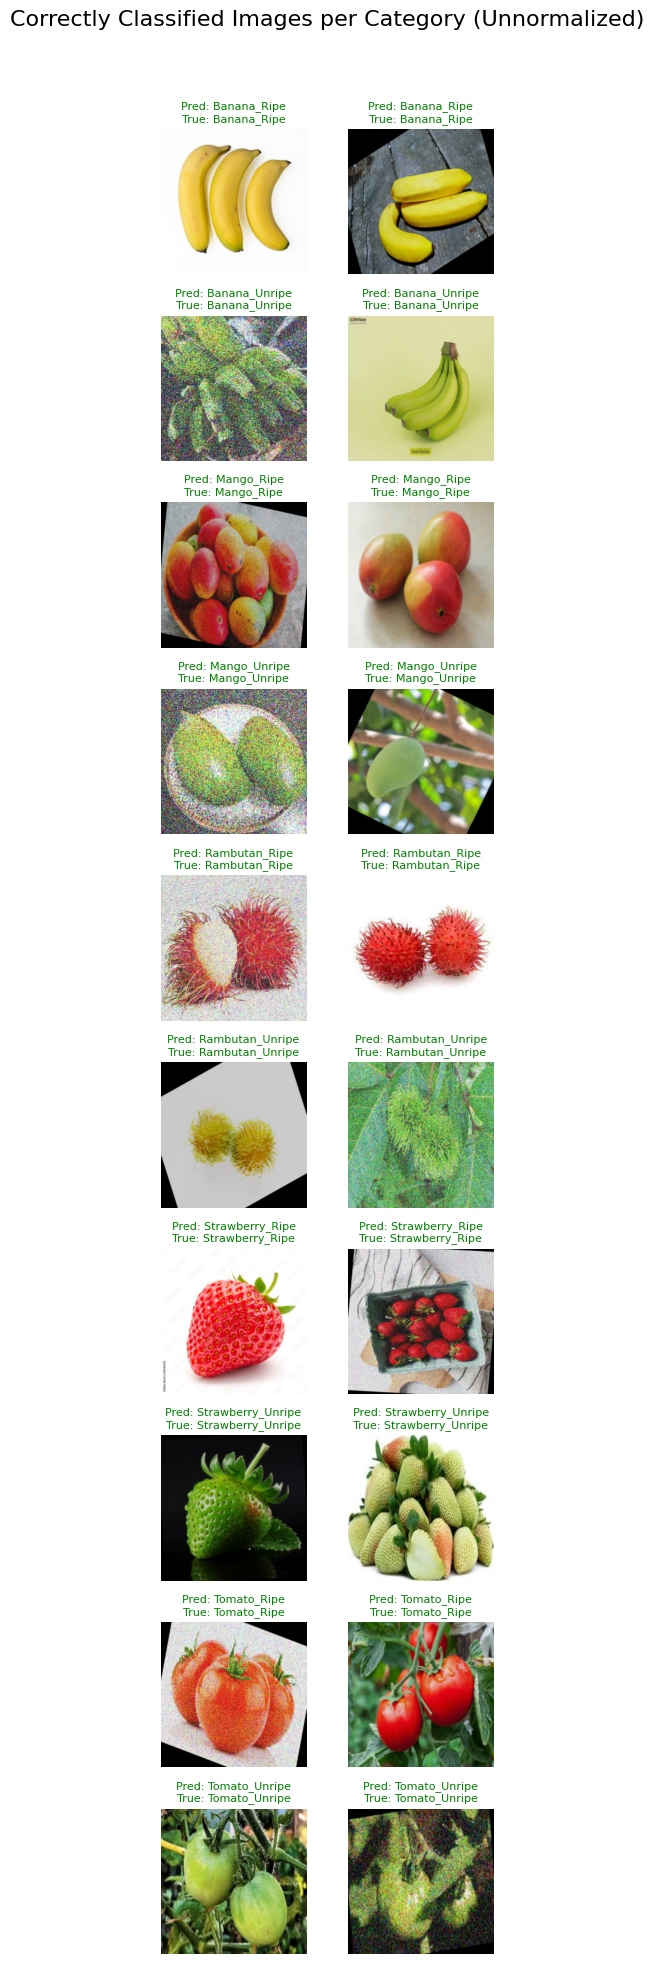

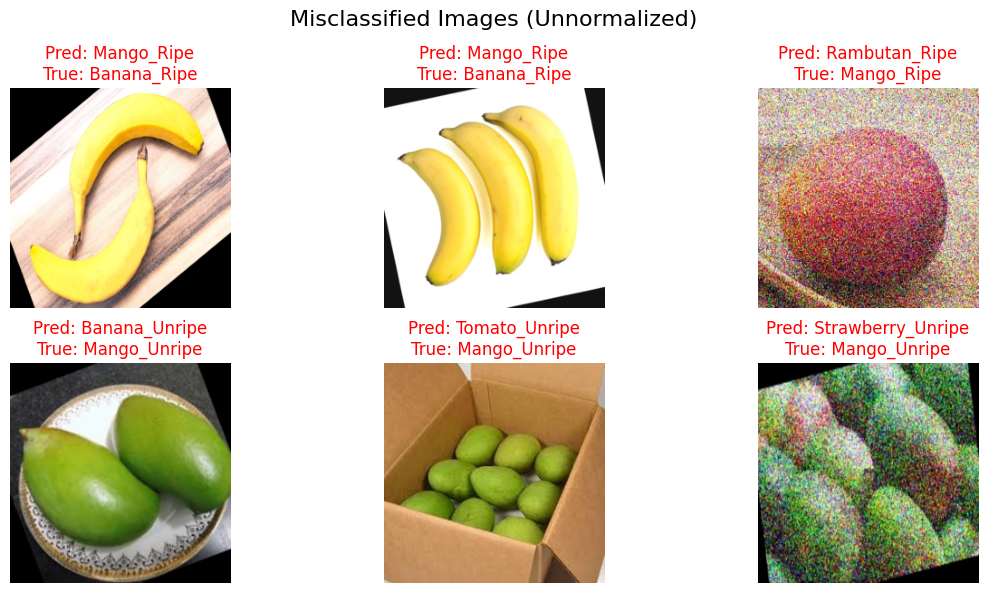

In [ ]:


def unnormalize(tensor, mean, std):
    mean = torch.tensor(mean).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(tensor.device)
    std = torch.tensor(std).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(tensor.device)
    tensor = tensor * std + mean
    return tensor

# Needs to be changed if used different values for normalization
mean_values = [0.5356, 0.4985, 0.3548]
std_values = [0.2257, 0.2288, 0.2137]


# Plot correctly classified images per category (Unnormalized)
num_rows_correct = len(train_dataset.classes)
num_cols = num_samples_per_class
plt.figure(figsize=(2 * num_cols, 2 * num_rows_correct))
plot_index = 1
for class_name, samples in correctly_classified_by_class.items():
    for img_tensor, pred_label, true_label in samples:
        # Unnormalize the tensor and remove batch dimension
        unnormalized_img_tensor = unnormalize(img_tensor, mean_values, std_values).squeeze(0)

        # Convert the unnormalized tensor to a PIL image
        img = transforms.ToPILImage()(unnormalized_img_tensor.cpu().clamp(0, 1))

        plt.subplot(num_rows_correct, num_cols, plot_index)
        plt.imshow(img)
        plt.title(f"Pred: {idx_to_class[pred_label]}\nTrue: {idx_to_class[true_label]}", color='green', fontsize=8)
        plt.axis("off")
        plot_index += 1
plt.tight_layout()
plt.suptitle("Correctly Classified Images per Category (Unnormalized)", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

# Plot misclassified images (Unnormalized)
plt.figure(figsize=(12, 6))
for i, (img_tensor, pred_label, true_label) in enumerate(misclassified[:6]):
    # Unnormalize the tensor and remove batch dimension
    unnormalized_img_tensor = unnormalize(img_tensor, mean_values, std_values).squeeze(0)

    # Convert the unnormalized tensor to a PIL image
    img = transforms.ToPILImage()(unnormalized_img_tensor.cpu().clamp(0, 1))

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {idx_to_class[pred_label]}\nTrue: {idx_to_class[true_label]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.suptitle("Misclassified Images (Unnormalized)", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()